## Goals
Mendapatkan pemahaman yang lebih baik tentang produk yang dijual di platform, perilaku pembelian pelanggan, dan faktor-faktor apa yang mempengaruhi keberhasilan penjualan suatu produk

## Objective
1. Kategori produk yang paling populer di Olist, baik dari segi jumlah penjualan maupun total nilai penjualan.
2. Distribusi harga produk di Olist, termasuk harga tertinggi, harga terendah, dan rata-rata harga produk.
3. Barang yang sering dibatalkan pembeliannya.

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from rapidfuzz import process, fuzz

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## Load Dataset

In [5]:
# access data db
def get_data(query):
    conn = sqlite3.connect("olist.db")
    cursor = conn.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()
    return data

In [6]:
def get_df(query):
    # get data
    conn = sqlite3.connect("olist.db")
    cursor = conn.cursor()
    cursor.execute(query)
    data = cursor.fetchall()

    # to dataframe
    col_names = [description[0] for description in cursor.description]
    df = pd.DataFrame(data, columns=col_names)
    conn.close()

    return df

## Data Preprocessing

### 1. Information of Tables

In [7]:
query = """
SELECT 
    name 
FROM 
    sqlite_master 
WHERE type='table'
"""

tables = get_data(query)
tables

[('olist_order_customer_dataset',),
 ('olist_order_dataset',),
 ('olist_order_reviews_dataset',),
 ('olist_order_payments_dataset',),
 ('olist_order_items_dataset',),
 ('olist_products_dataset',),
 ('olist_sellers_dataset',),
 ('olist_geolocation_dataset',),
 ('product_category_name_translation',)]

In [8]:
query = """
SELECT
    *
FROM 
    olist_order_dataset
"""
df_order = get_df(query)

df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          99441 non-null  int64 
 1   order_id                       99441 non-null  object
 2   customer_id                    99441 non-null  object
 3   order_status                   99441 non-null  object
 4   order_purchase_timestamp       99441 non-null  object
 5   order_approved_at              99281 non-null  object
 6   order_delivered_carrier_date   97658 non-null  object
 7   order_delivered_customer_date  96476 non-null  object
 8   order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


In [9]:
query = """
SELECT
    *
FROM 
    olist_order_items_dataset
"""
df_order_items = get_df(query)

df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                112650 non-null  int64  
 1   order_id             112650 non-null  object 
 2   order_item_id        112650 non-null  int64  
 3   product_id           112650 non-null  object 
 4   seller_id            112650 non-null  object 
 5   shipping_limit_date  112650 non-null  object 
 6   price                112650 non-null  float64
 7   freight_value        112650 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB


In [10]:
query = """
SELECT
    *
FROM 
    olist_products_dataset
"""
df_products= get_df(query)

df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       32951 non-null  int64  
 1   product_id                  32951 non-null  object 
 2   product_category_name       32341 non-null  object 
 3   product_name_lenght         32341 non-null  float64
 4   product_description_lenght  32341 non-null  float64
 5   product_photos_qty          32341 non-null  float64
 6   product_weight_g            32949 non-null  float64
 7   product_length_cm           32949 non-null  float64
 8   product_height_cm           32949 non-null  float64
 9   product_width_cm            32949 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ MB


In [11]:
query = """
SELECT
    *
FROM 
    product_category_name_translation
"""
df_translate= get_df(query)

df_translate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          71 non-null     int64 
 1   product_category_name          71 non-null     object
 2   product_category_name_english  71 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


### 2. Data Wrangling

In [12]:
query = """
SELECT
    oi.order_id,
    p.product_id,
    oi.order_item_id,
    t.product_category_name_english AS product_name,
    oi.price,
    o.order_status
FROM 
    olist_order_items_dataset oi
LEFT JOIN 
    olist_products_dataset p ON oi.product_id = p.product_id
LEFT JOIN 
    product_category_name_translation t ON p.product_category_name = t.product_category_name
LEFT JOIN 
    olist_order_dataset o ON oi.order_id = o.order_id
"""

df = get_df(query)
df

,order_id,product_id,order_item_id,product_name,price,order_status
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,cool_stuff,58.90,delivered
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,pet_shop,239.90,delivered
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,furniture_decor,199.00,delivered
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,perfumery,12.99,delivered
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,garden_tools,199.90,delivered
...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,1,housewares,299.99,delivered
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,1,computers_accessories,350.00,delivered
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,1,sports_leisure,99.90,delivered
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,1,computers_accessories,55.99,delivered


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       112650 non-null  object 
 1   product_id     112650 non-null  object 
 2   order_item_id  112650 non-null  int64  
 3   product_name   111023 non-null  object 
 4   price          112650 non-null  float64
 5   order_status   112650 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.2+ MB


### 3. Data Cleaning

In [14]:
df_desc = []

for i in df.columns:
    df_desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum()) / (len(df))) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(df_desc, columns = ['Data Features', 'Data Type', 'Null', 'Null (%)', 'Unique', 'Unique Sample'])

,Data Features,Data Type,Null,Null (%),Unique,Unique Sample
0,order_id,object,0,0.00,98666,"[26bd26a21d87b4594128d26b3b24e8d8, 12224004d32..."
1,product_id,object,0,0.00,32951,"[2f282449dadb2e59ff2afcde0bd9f393, f3ae4b9a1e8..."
2,order_item_id,int64,0,0.00,21,"[10, 1]"
3,product_name,object,1627,1.44,71,"[books_technical, food]"
4,price,float64,0,0.00,5968,"[510.0, 123.89]"
5,order_status,object,0,0.00,7,"[shipped, delivered]"


### 3.1 Handling Missing Values

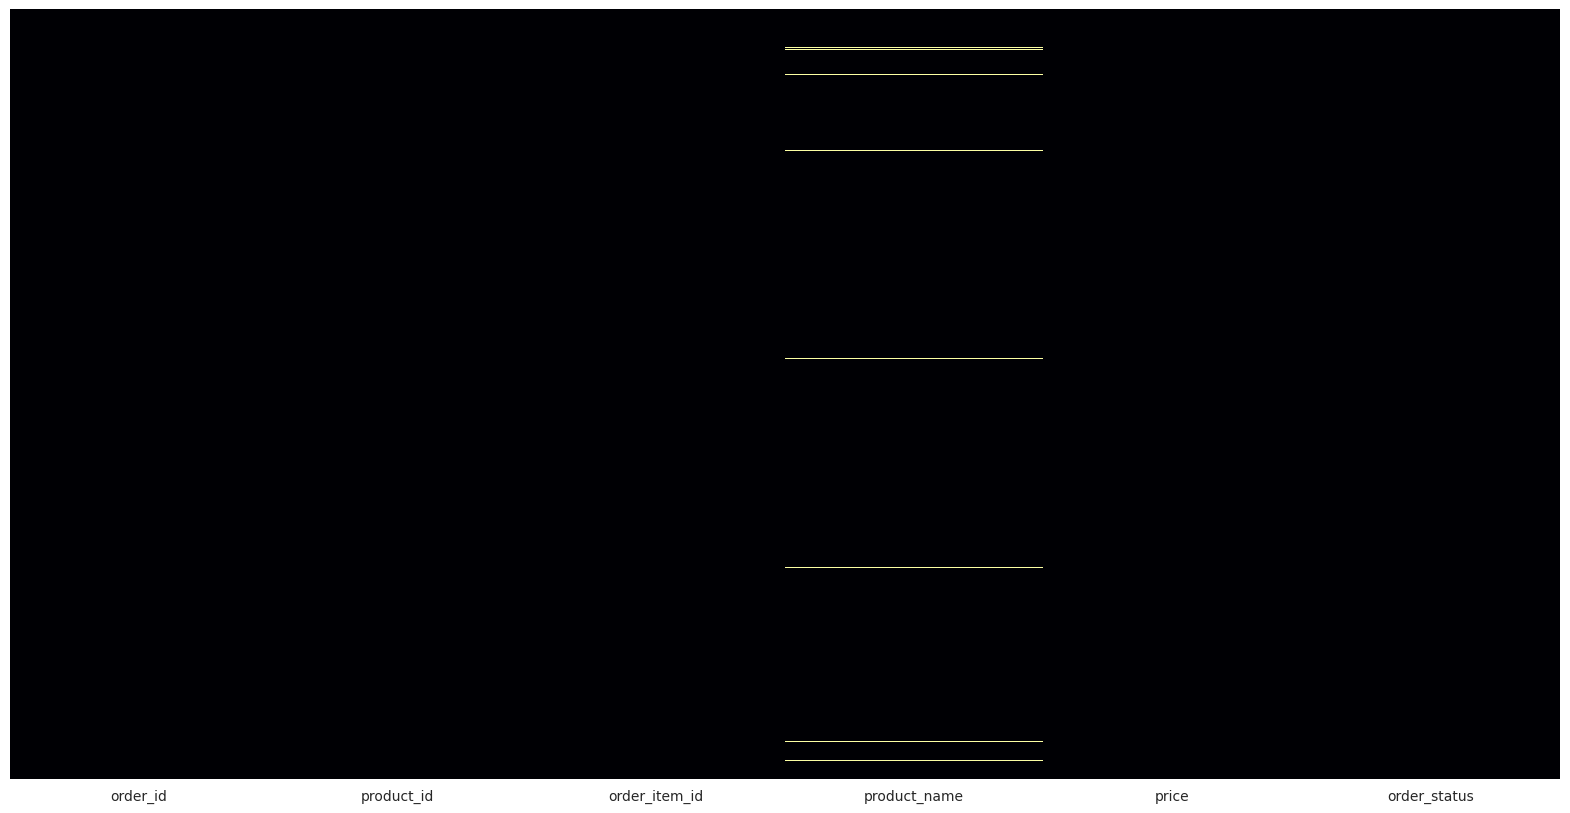

In [15]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), yticklabels=False, cmap='inferno', cbar=False)
plt.show()

In [16]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print(f'{i}, null sebesar {round(df[i].isna().mean()*100,2)}%, total null {df[i].isna().sum()}')

product_name, null sebesar 1.44%, total null 1627


In [17]:
df.dropna(inplace=True)

Pada kolom product_name hanya memiliki null sebesar 1,44% yang mana dikategorikan sangat kecil sehingga tidak memberikan efek signifikan pada dataset. Serta untuk menghindari bias pada analisis jika ingin melakukan analisis berupa pengkategorian pada product_name

### 3.2 Handling Inconsistent Format

In [18]:
df['product_name'].unique()[:5]

array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools'], dtype=object)

In [19]:
# change the product name
df['product_name'] = df['product_name'].str.replace('_',' ')
df['product_name'].unique()[:5]

array(['cool stuff', 'pet shop', 'furniture decor', 'perfumery',
       'garden tools'], dtype=object)

In [20]:
def check_similar_text(col_name):
    # define result
    result = []

    # define variable
    if df[col_name].dtype != 'object':
        raise ValueError('kolom haris berupa object')
    list_str = df[col_name].unique()

    # check every values
    for val in list_str:
        # process
        temp_res = process.extract(val, list_str, scorer=fuzz.token_sort_ratio, score_cutoff=80)

        # loops for every match or similar with values and not with their self
        for (match_text, score_text, _) in temp_res:
            if score_text < 100:
                result.append({
                    'value' : val,
                    'match' : match_text,
                    'score' : score_text
                })

    # result condition
    if len(result) == 0:
        return 'Tidak ada nilai yang mirip'

    else:
        return pd.DataFrame(result)

In [21]:
check_similar_text('order_status')

'Tidak ada nilai yang mirip'

In [22]:
check_similar_text('product_name')

,value,match,score
0,construction tools lights,costruction tools tools,83.333333
1,construction tools lights,construction tools safety,80.000000
2,home appliances,home appliances 2,93.750000
3,home confort,home comfort 2,84.615385
4,costruction tools garden,construction tools safety,81.632653
5,construction tools safety,costruction tools garden,81.632653
6,construction tools safety,construction tools lights,80.000000
7,fashion male clothing,fashio female clothing,93.023256
8,home appliances 2,home appliances,93.750000
9,fashio female clothing,fashion male clothing,93.023256


Terlihat terdapat kesalahan ketik pada beberapa produk berbahasa inggris namun masih bisa di toleransi karena tidak mengakibatkan kesalahan pada dataset atau duplikasi nama yang sama diakibatkan kesalahan penulisan. Terlihat juga terdapat nama produk yang sama namun berbeda tipe karena terdapat angka dibelakangnya, yang diasumsikan sebagai jenis kategori produk yang hampir sama namun berbeda secara detailnya, sehingga tidak dilakukan perubahan atas nama produknya.

### 3.3 Handling Outliers

In [23]:
def plot_dist(data):
    # split subplot
    f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (1, 4)})
    
    # add visualization
    ax_hist.axvline(x=data.mean(), linewidth=2, color = 'k', label='mean') 
    ax_hist.axvline(x=data.median(), linewidth=2, color = 'r', label='median')
    sns.boxplot(x=data, ax=ax_box)
    sns.distplot(data, ax=ax_hist, hist=True, kde=True)
    ax_hist.legend()

    # remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

In [24]:
def desc_stat(data):
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    lower_whiker = q1 - 1.5 * iqr
    upper_whiker = q3 + 1.5 * iqr

    return pd.DataFrame({
        'Mean': data.mean(),
        'Median': data.median(),
        'Mode': data.mode().iloc[0],
        'Min' : data.min(),
        'Max' : data.max(),
        'Q1': q1,
        'Q3': q3, 
        'Std Deviation': data.std(),
        'Lower Whisker': lower_whiker,
        'Upper Whisker': upper_whiker
    }, index=[0])

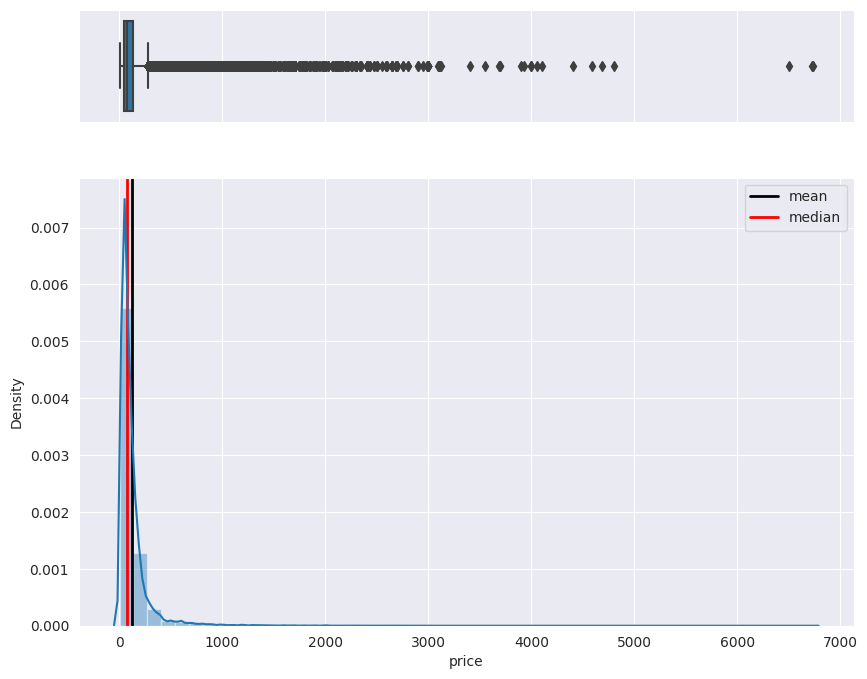

,Mean,Median,Mode,Min,Max,Q1,Q3,Std Deviation,Lower Whisker,Upper Whisker
0,120.755104,74.99,59.9,0.85,6735.0,39.9,134.9,183.372746,-102.6,277.4


In [25]:
data = df['price']
plot_dist(data)
desc_stat(data)

In [26]:
 df[df['price']>6000]

,order_id,product_id,order_item_id,product_name,price,order_status
3556,0812eb902a67711a1cb742b3cdaa65ae,489ae2aa008f021502940f251d4cce7f,1,housewares,6735.0,delivered
107841,f5136e38d1a14a4dbd87dff67da82701,1bdf5e6731585cf01aa8169c7028d6ad,1,art,6499.0,delivered
112233,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,1,computers,6729.0,delivered


Berdasarkan data price terdapat banyak outliers. Namun outliers tersebut tidak dihapus karena pada outliers tersebut mengandung beberapa informasi penting mengenai harga produk - produk pada dataset, yang mana pada dataset memiliki keberagaman jenis barang yang berbeda satu sama lain.

### 3.4 Handling Duplicate

In [27]:
df.duplicated().sum()

0

Tidak terdapat data duplikat pada dataset sehingga tidak perlu melakukan penghapusan data yang duplikat.

## 4. Analysis

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111023 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       111023 non-null  object 
 1   product_id     111023 non-null  object 
 2   order_item_id  111023 non-null  int64  
 3   product_name   111023 non-null  object 
 4   price          111023 non-null  float64
 5   order_status   111023 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.9+ MB


### 4.1 Produk Terlaris pada Olist

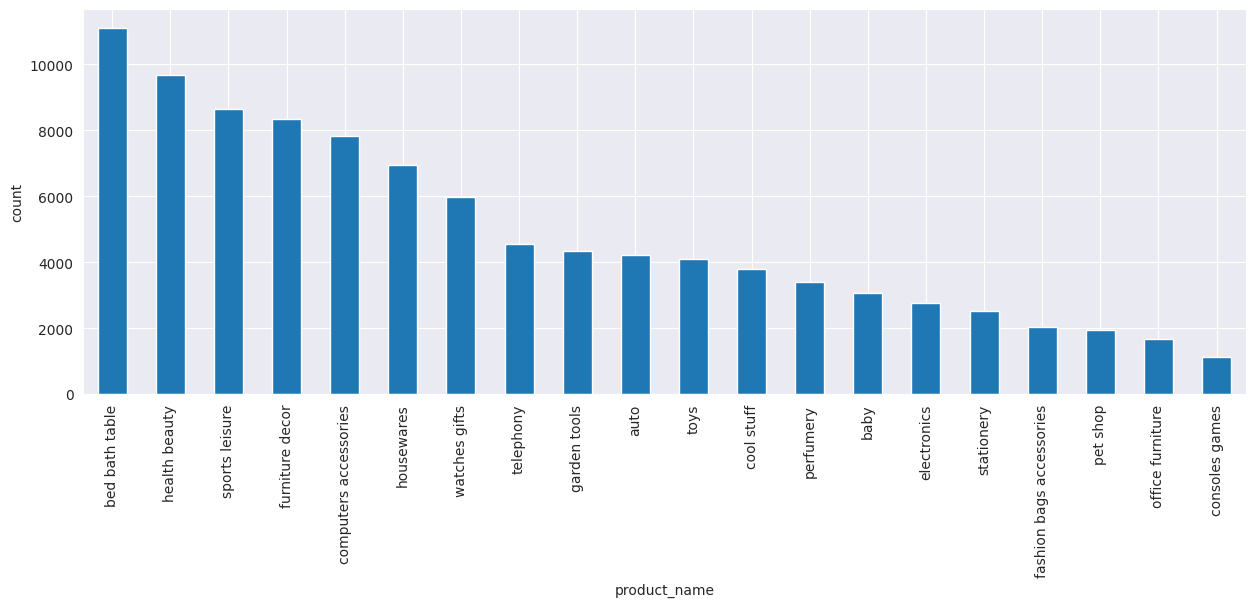

In [29]:
# grouping data
temp = df.groupby(['product_name'])['order_id'].count().sort_values(ascending=False)

# plotting bar
plt.figure(figsize=(15,5))
temp.head(20).plot(kind='bar')
plt.ylabel('count')
plt.show()

In [30]:
temp.head(20)

product_name
bed bath table              11115
health beauty                9670
sports leisure               8641
furniture decor              8334
computers accessories        7827
housewares                   6964
watches gifts                5991
telephony                    4545
garden tools                 4347
auto                         4235
toys                         4117
cool stuff                   3796
perfumery                    3419
baby                         3065
electronics                  2767
stationery                   2517
fashion bags accessories     2031
pet shop                     1947
office furniture             1691
consoles games               1137
Name: order_id, dtype: int64

In [31]:
temp[['bed bath table','housewares','garden tools']].sum()

22426

In [32]:
temp[['health beauty','perfumery']].sum()

13089

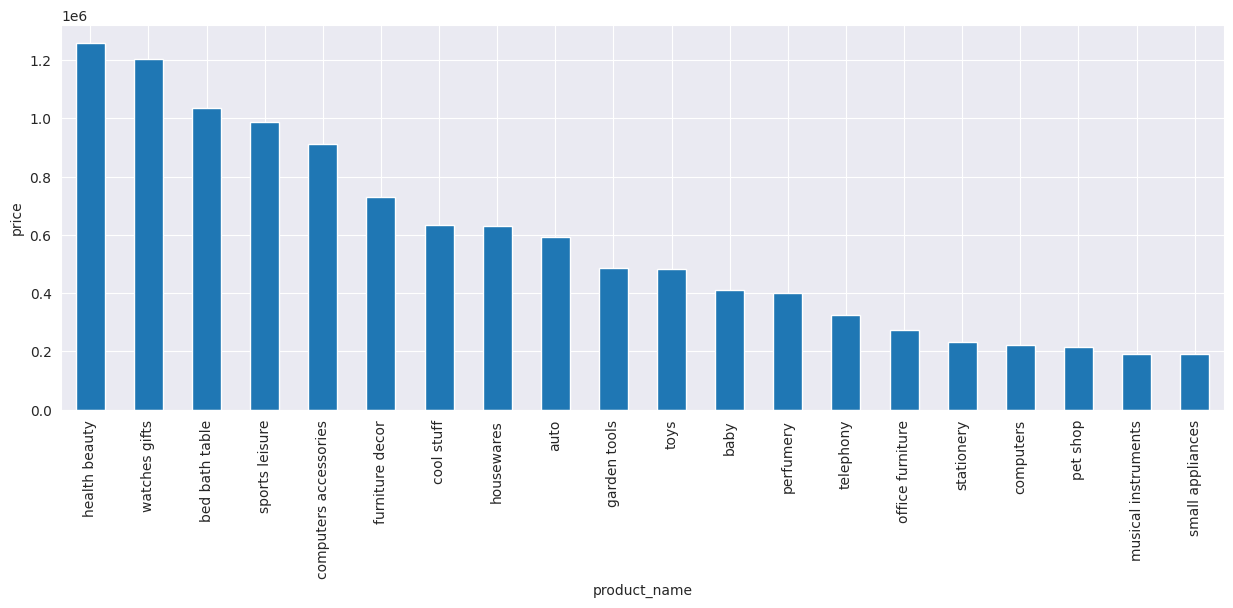

In [33]:
# grouping data
temp = df.groupby(['product_name'])['price'].sum().sort_values(ascending=False)

# plotting bar
plt.figure(figsize=(15,5))
temp.head(20).plot(kind='bar')
plt.ylabel('price')
plt.show()

In [34]:
temp.head(20)

product_name
health beauty            1258681.34
watches gifts            1205005.68
bed bath table           1036988.68
sports leisure            988048.97
computers accessories     911954.32
furniture decor           729762.49
cool stuff                635290.85
housewares                632248.66
auto                      592720.11
garden tools              485256.46
toys                      483946.60
baby                      411764.89
perfumery                 399124.87
telephony                 323667.53
office furniture          273960.70
stationery                230943.23
computers                 222963.13
pet shop                  214315.41
musical instruments       191498.88
small appliances          190648.58
Name: price, dtype: float64

In [35]:
temp[['bed bath table','housewares','garden tools']].sum()

2154493.8000000003

In [36]:
temp[['health beauty','perfumery']].sum()

1657806.21

### 4.2 Distribusi Harga Produk Olist

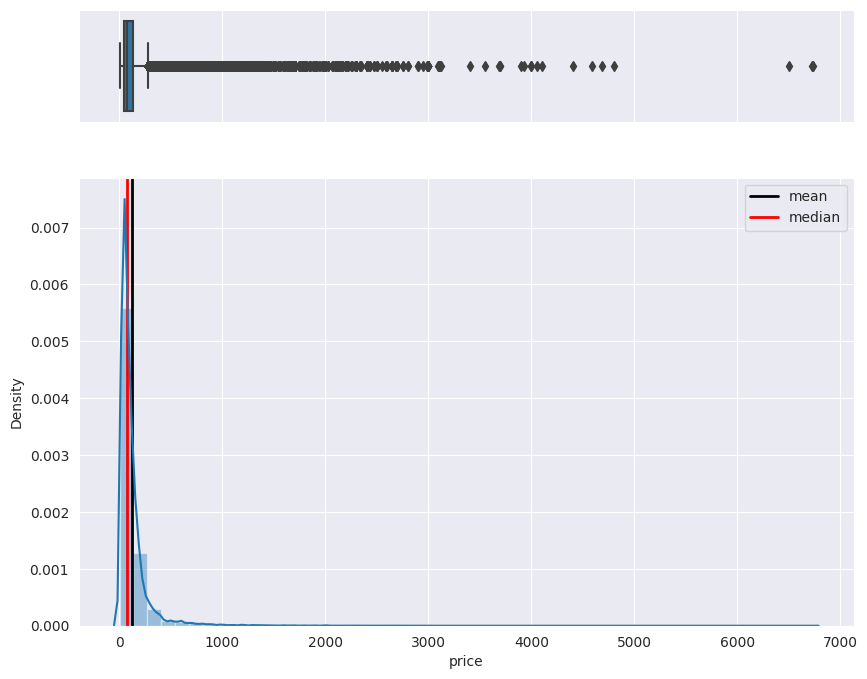

,Mean,Median,Mode,Min,Max,Q1,Q3,Std Deviation,Lower Whisker,Upper Whisker
0,120.755104,74.99,59.9,0.85,6735.0,39.9,134.9,183.372746,-102.6,277.4


In [37]:
data = df['price']
plot_dist(data)
desc_stat(data)

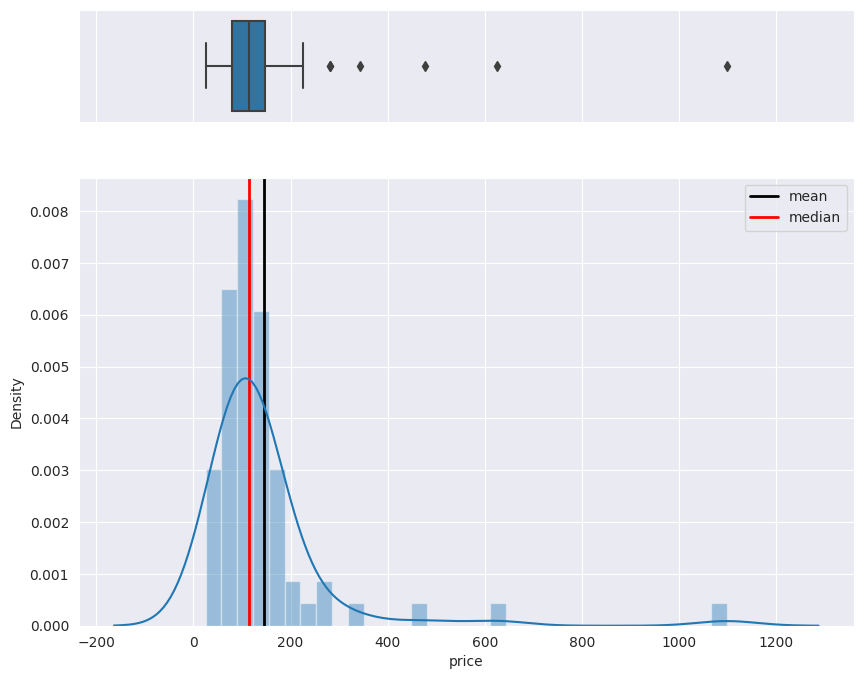

,Mean,Median,Mode,Min,Max,Q1,Q3,Std Deviation,Lower Whisker,Upper Whisker
0,144.778802,114.344285,25.342333,25.342333,1098.340542,79.56625,147.402966,147.546088,-22.188825,249.158041


In [38]:
data = df.groupby(['product_name'])['price'].mean()
plot_dist(data)
desc_stat(data)

In [39]:
df_temp = df.groupby(['product_name'])['price'].mean().to_frame()
df_temp[df_temp['price']>249]

,price
product_name,
agro industry and commerce,342.124858
computers,1098.340542
home appliances 2,476.124958
musical instruments,281.616000
small appliances,280.778468
small appliances home oven and coffee,624.285658


### 4.3 Produk yang sering Gagal dalam Transaksi

In [44]:
df['order_status'].unique()

array(['delivered', 'shipped', 'canceled', 'invoiced', 'processing',
       'approved', 'unavailable'], dtype=object)

In [40]:
# feature engineering for order status
df['order_status_cat'] = df['order_status'].map({
    'delivered' : 'success',
    'shipped' : 'processed',
    'canceled' : 'failed',
    'invoiced' : 'processed',
    'processing' : 'processed',
    'approved' : 'success',
    'unavailable' : 'failed'
})

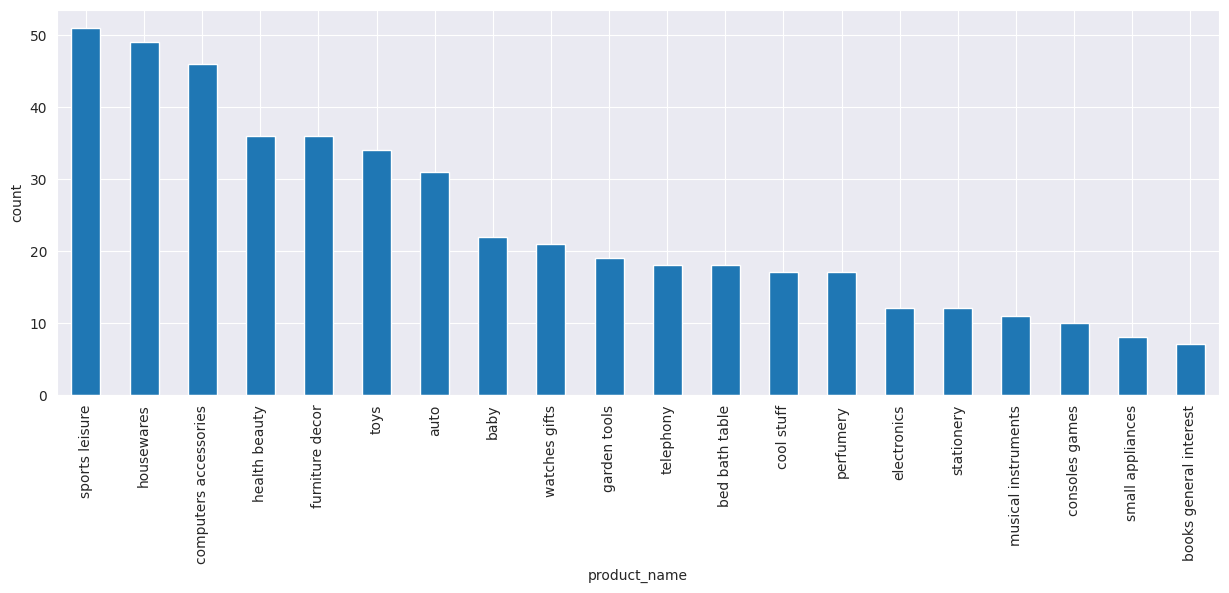

In [48]:
# grouping data
temp = df[df['order_status_cat']=='failed'].groupby(['product_name'])['order_id'].count().sort_values(ascending=False)

# plotting bar
plt.figure(figsize=(15,5))
temp.head(20).plot(kind='bar')
plt.ylabel('count')
plt.show()

In [49]:
temp.head(20)

product_name
sports leisure            51
housewares                49
computers accessories     46
health beauty             36
furniture decor           36
toys                      34
auto                      31
baby                      22
watches gifts             21
garden tools              19
telephony                 18
bed bath table            18
cool stuff                17
perfumery                 17
electronics               12
stationery                12
musical instruments       11
consoles games            10
small appliances           8
books general interest     7
Name: order_id, dtype: int64

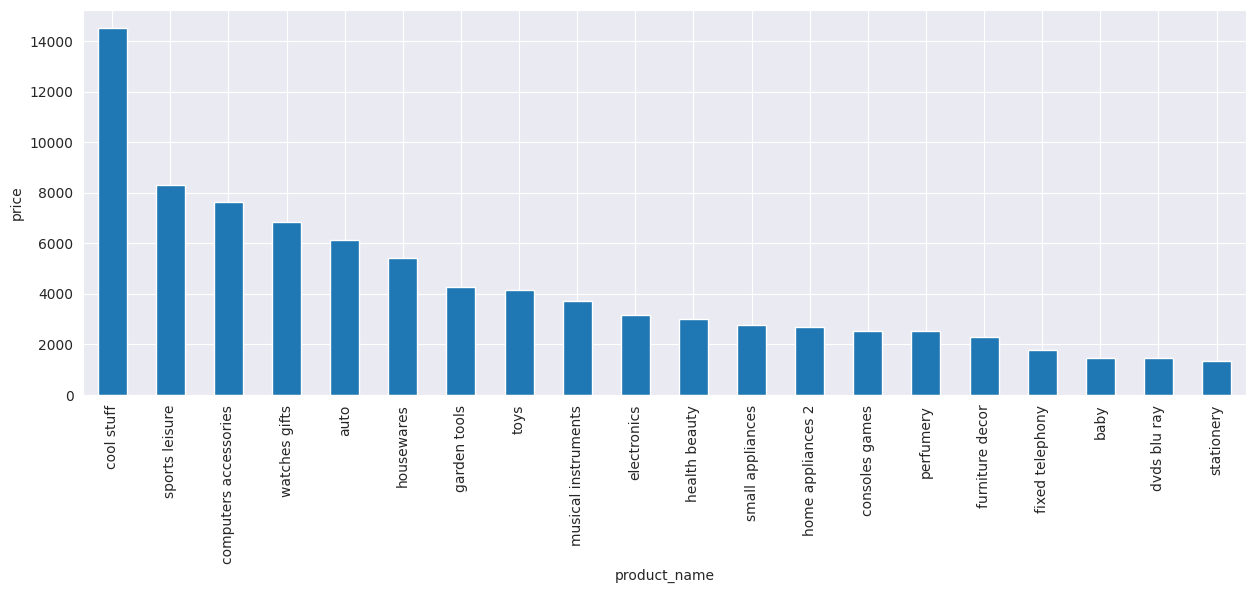

In [46]:
# grouping data
temp = df[df['order_status_cat']=='failed'].groupby(['product_name'])['price'].sum().sort_values(ascending=False)

# plotting bar
plt.figure(figsize=(15,5))
temp.head(20).plot(kind='bar')
plt.ylabel('price')
plt.show()

In [47]:
temp.head(20)

product_name
cool stuff               14520.36
sports leisure            8308.05
computers accessories     7632.30
watches gifts             6820.47
auto                      6134.38
housewares                5422.86
garden tools              4246.52
toys                      4138.06
musical instruments       3710.44
electronics               3167.20
health beauty             2986.21
small appliances          2741.32
home appliances 2         2668.00
consoles games            2537.95
perfumery                 2525.56
furniture decor           2297.44
fixed telephony           1758.79
baby                      1452.69
dvds blu ray              1439.90
stationery                1349.39
Name: price, dtype: float64